In [86]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

import re ,fasttext,pickle
from nltk.corpus import stopwords
from textblob import TextBlob
STOPWORDS =  stopwords.words("english")

## Table of contents 
-  some basic EDA and setup 
-  Fasttext 
-  Vader sentiment 
-  Text blob 
-  Custom ML Model

In [61]:
def clean_text(text):
	text = str(text).lower()
	text = re.sub("[^\w\s]"," ",text)
	text =  ' '.join([w for w in text.split() if w not in STOPWORDS])
	return text

## Some basic processing 

In [62]:
df  = pd.read_csv("./customer_feedback.csv",quotechar='"',sep=",")
df = df.iloc[:, 0].str.split(',', expand=True) # 'expand=True' Returns a 'DataFrame' not a list(default mode)
df.columns = ['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']
df = df.drop(columns=["Date/Time","User ID","Location","Confidence Score"])
df["cleaned"] = df["Text"].apply(lambda  x : clean_text(x))
df["Sentiment"] =  df["Sentiment"].map({" Positive":1," Negative":0}).astype("Int32")
counts =  df.Source.value_counts()
df["Source"] = df["Source"].where(
    df["Source"].map(counts) >= 6,
    "Others" )
df.dropna()
print("Shape :",df.shape)
df.head()

Shape : (98, 4)


,Text,Sentiment,Source,cleaned
0,"""I love this product!""",1,Others,love product
1,"""The service was terrible.""",0,Yelp Reviews,service terrible
2,"""This movie is amazing!""",1,IMDb,movie amazing
3,"""I'm so disappointed with their customer suppo...",0,Others,disappointed customer support
4,"""Just had the best meal of my life!""",1,TripAdvisor,best meal life


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Others'),
  Text(1, 0, ' Yelp Reviews'),
  Text(2, 0, ' IMDb'),
  Text(3, 0, ' TripAdvisor'),
  Text(4, 0, ' Spotify'),
  Text(5, 0, ' Goodreads'),
  Text(6, 0, ' Online Store'),
  Text(7, 0, ' Zomato'),
  Text(8, 0, ' Website Review')])

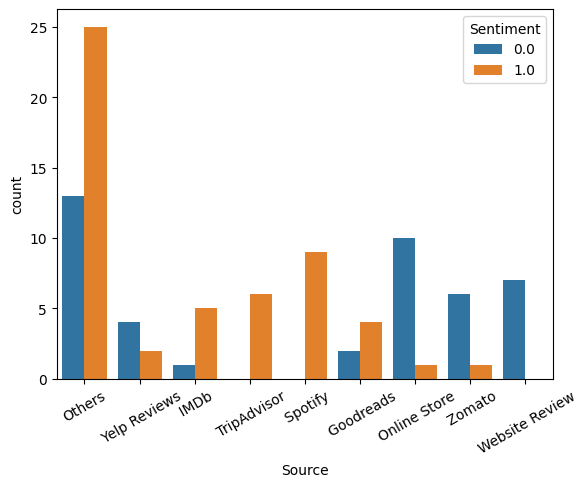

In [63]:
counts_new = df.Source.value_counts()
sns.countplot(data=df,x="Source",hue="Sentiment")
plt.xticks(rotation=30)


<Axes: xlabel='Sentiment', ylabel='count'>

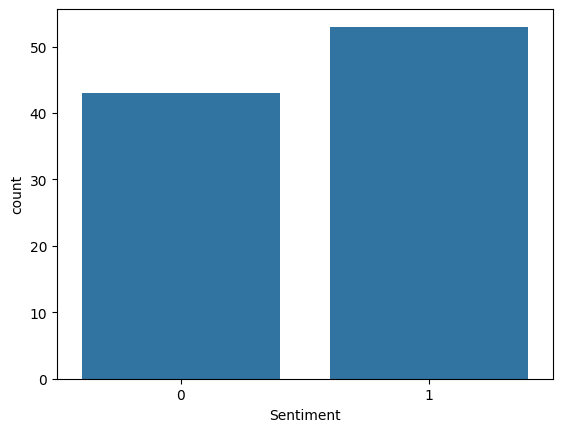

In [64]:
sns.countplot(data=df,x="Sentiment")

## Vader sentiment 

In [65]:
model =  SentimentIntensityAnalyzer()

def extract_score(text):
    score = model.polarity_scores(text)

    if score['pos'] >=  score['neg']:
        sentiment = 1
    else:
        sentiment = 0 
    return sentiment


In [66]:
df['vader_scores'] = df['cleaned'].apply(extract_score)
df[["cleaned","Sentiment","vader_scores"]].head()

,cleaned,Sentiment,vader_scores
0,love product,1,1
1,service terrible,0,0
2,movie amazing,1,1
3,disappointed customer support,0,0
4,best meal life,1,1


In [67]:
df = df.dropna(subset=['Sentiment', 'vader_scores'])
acc = accuracy_score(df['Sentiment'],df['vader_scores'])
print("Vader sentiment acc : ",acc)

Vader sentiment acc :  0.90625


## Fasttext 

In [68]:
x_train,x_test,y_train,y_test =  train_test_split(df["cleaned"].values,df["Sentiment"].values,test_size=0.2,random_state=42)
print("Train size : " ,x_train.shape[0])
print("test size :" ,x_test.shape[0])

Train size :  76
test size : 20


In [75]:


mapper  =  lambda x :  "positive" if x=="1" else "negative"
train = pd.DataFrame()
train['final_data'] = labeled_data = [
    f"__label__{mapper(str(y))} {x}"
    for x, y in zip(x_train, y_train)
]

## old method :  "__label__"+y_train+" "+x_train

## data format : __label__positive thank you

test = pd.DataFrame()
test['final_data'] =  labeled_data = [
    f"__label__{mapper(str(y))} {x}"
    for x, y in zip(x_test, y_test)
]


train.to_csv("train.csv",columns=['final_data'],index=False,header=False) ## compulsory
test.to_csv("test.csv",columns=['final_data'],index=False,header=False) ## compulsory
train.head()

,final_data
0,__label__positive song always puts good mood g...
1,__label__negative food restaurant disappointin...
2,__label__negative website confusing poorly des...
3,__label__positive playlist perfect relaxation ...
4,__label__negative customer service terrible


In [90]:
model  =  fasttext.train_supervised(input="train.csv")
n_samples_tested , precision, recall = model.test('test.csv')

print("No of samples tested : ",n_samples_tested)
print("Precision : ",precision)
print("Recall :",recall)

model.save_model("models/fasttext_model.bin")
F_measure = 2 * (precision *recall) / (precision + recall)
print("Fastext Acc : ",F_measure) 

No of samples tested :  20
Precision :  0.75
Recall : 0.75
Fastext Acc :  0.75


## TextBlob 

In [77]:
def sentiment_analyzer(review):
    sentiment= TextBlob(review)
    score= sentiment.sentiment.polarity
    if score >= 0:
        return 1
    elif score < 0:
        return 0 
    

df["blob_scores"] =  df["cleaned"].apply(lambda x :  sentiment_analyzer(x))
df = df.dropna(subset=['Sentiment', 'blob_scores'])
acc_blob = accuracy_score(df['Sentiment'],df['blob_scores'])
print("Text Blob sentiment acc : ",acc_blob)

Text Blob sentiment acc :  0.9583333333333334


## Custom Ml Model

In [81]:
tfidf =  TfidfVectorizer()

x_train_tf =  np.array(tfidf.fit_transform(x_train).todense())
x_test_tf = np.array( tfidf.transform(x_test).todense())
print("X train tf shape :",x_train_tf.shape)
x_train_tf

X train tf shape : (76, 202)


array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.5031256,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], shape=(76, 202))

In [89]:


models_dict = {"rf":RandomForestClassifier,"xgb":XGBClassifier,"nb":GaussianNB}

for name,model_name in models_dict.items():
    model = model_name()
    model.fit(x_train_tf,y_train)
    print(f"{name.upper()} Score : ",model.score(x_test_tf,y_test))
    with open(f"models/{name}_model.pkl", "wb") as f:
        pickle.dump(model, f)
    


RF Score :  0.75
XGB Score :  0.8
NB Score :  0.95


**Clearly Our best model is NaiveBayes you can try out diff models too 🤗🤗🤗**

## Thanx a lot for visiting..... 🤗🤗🤗